# 파이썬 활용 디지털마케팅 데이터분석 및 기획

# Today's mission

- 신규 지표 개발
- 문제 정의(배경 및 목적)
- 분석 프레임(지표 생성 과정, 추가 고려사항)
- 데이터 탐색 및 변수 선정(판정 기준 선택&패턴 이해)
- 데이터 전처리 및 분석(변수 탐색 및 선정)
- 신규 스코어 산출 및 대시보드 구축(모델 학습 및 가중치 산출, 대시보드 생성)
- 신규 지표 개발 : 분석 보고서 작성 및 결과 토론

]

## Day05-3A  신규 지표 개발 (실습) - 데이터 전처리

- 데이터 전처리 및 분석(변수 탐색 및 선정)
- 신규 스코어 산출 및 대시보드 구축(모델 학습 및 가중치 산출, 대시보드 생성)

### 지표 개발을 위한 변수 탐색 (Activation 을 측정하는 Single Index 개발)
- 목적
    - all 기준으로 일별 트래킹을 하는 방식을 기본으로 세팅 
    - 추가로, 보다 정교한 지표 수식 개발을 위해 Feature selection 진행
        - 중요도가 높은 feature를 조합(가중치부여)하여 index 개발
     - Feature Selection을 위해 데이터셋 가공
         - 이전 주차 행동 및 다음 주차 **Retention** 여부!
         - 일별 all 기준 DAU는 코호트 방식이 고려되지 않음
         - source: [link](https://medium.com/analytics-for-humans/a-beginners-guide-to-cohort-analysis-the-most-actionable-and-underrated-report-on-google-c0797d826bf4)
         
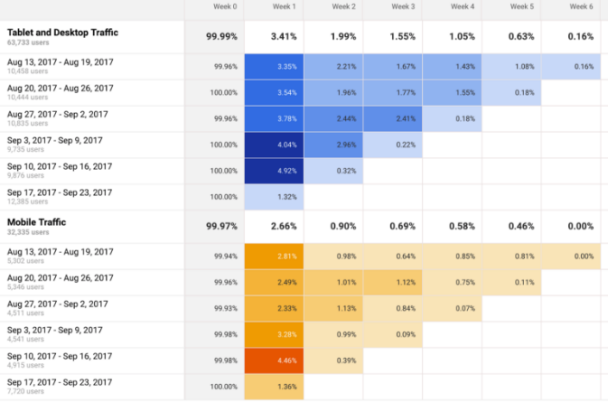        

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### 특정 1주간 이용행동 데이터 탐색

- 탐색 데이터셋 종류
     - 1) 특정 주의 사용행동
     - 2) 그 다음주의 사용행동 & 방문 여부
- 탐색 목적
    - 첫주 -> 다음주(리텐션)에 변수별 미치는 영향력 판단
     
- 1) 유저id 별 특정 1주간 행동별 카운트
    - filecount: 이용한 파일수
    - opencount: 열람한 파일수
    - savecount: 저장한 파일수
    - exportcount: 내보내기 파일수
    - traffic: 사용량 트래픽(byte)
    - visitcount: 1주간 방문일수(최소 1일, 최대 7일)     

In [2]:
tf = pd.read_csv("data/lc1.csv", index_col=0)

In [3]:
tf.head()

,iduser,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
0,10100018739106,6.0,12.0,0.0,0.0,3504812.0,0.0,0.0,12.0
1,10100037810674,8.0,23.0,0.0,0.0,17123098.0,0.0,0.0,23.0
2,10100036273719,4.0,4.0,0.0,0.0,2234363.0,0.0,0.0,4.0
3,10100027752244,5.0,6.0,2.0,0.0,602361.0,210114.0,0.0,6.0
4,10100000624840,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
tf.tail()

,iduser,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
99995,10100014533282,6.0,16.0,0.0,0.0,10256715.0,0.0,0.0,16.0
99996,10100037382422,17.0,33.0,0.0,0.0,3147566.0,0.0,0.0,41.0
99997,10100024157271,5.0,6.0,0.0,0.0,752028.0,0.0,0.0,6.0
99998,10100022150627,11.0,27.0,0.0,0.0,15296225.0,151805.0,0.0,27.0
99999,10100021804275,8.0,25.0,0.0,0.0,215101072.0,0.0,0.0,25.0


In [5]:
tf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   iduser         100000 non-null  int64  
 1   filecount      92120 non-null   float64
 2   opencount      74352 non-null   float64
 3   savecount      74352 non-null   float64
 4   exportcount    74352 non-null   float64
 5   viewtraffic    74352 non-null   float64
 6   edittraffic    74352 non-null   float64
 7   exporttraffic  74352 non-null   float64
 8   visitcount     82535 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 7.6 MB


In [6]:
tf.shape

(100000, 9)

### 데이터 전처리
- 인덱스 설정
- 트래픽 단위 변환
- 아웃라이어 제거
- 파생변수 생성
- 테이블 조인

In [7]:
tf.iduser.is_unique

True

In [8]:
tf.set_index("iduser", inplace=True)

In [9]:
tf.head()

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
iduser,,,,,,,,
10100018739106,6.0,12.0,0.0,0.0,3504812.0,0.0,0.0,12.0
10100037810674,8.0,23.0,0.0,0.0,17123098.0,0.0,0.0,23.0
10100036273719,4.0,4.0,0.0,0.0,2234363.0,0.0,0.0,4.0
10100027752244,5.0,6.0,2.0,0.0,602361.0,210114.0,0.0,6.0
10100000624840,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
tf = tf.fillna(0)

In [11]:
# byte -> mb
tf.viewtraffic = (tf.viewtraffic/1024/1024).round(0).astype(int)
tf.edittraffic = (tf.edittraffic/1024/1024).round(0).astype(int)
tf.exporttraffic = (tf.exporttraffic/1024/1024).round(0).astype(int)

In [12]:
tf.head()

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
iduser,,,,,,,,
10100018739106,6.0,12.0,0.0,0.0,3,0,0,12.0
10100037810674,8.0,23.0,0.0,0.0,16,0,0,23.0
10100036273719,4.0,4.0,0.0,0.0,2,0,0,4.0
10100027752244,5.0,6.0,2.0,0.0,1,0,0,6.0
10100000624840,24.0,0.0,0.0,0.0,0,0,0,0.0


In [13]:
tf.describe().apply(lambda x: x.round(2))

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,9.09,18.11,2.02,0.01,18.02,0.51,0.00,20.24
std,7.22,32.83,15.39,0.28,122.47,6.58,0.44,34.01
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
50%,7.00,8.00,0.00,0.00,2.00,0.00,0.00,10.00
75%,13.00,22.00,0.00,0.00,12.00,0.00,0.00,25.00
max,31.00,1643.00,1144.00,42.00,26951.00,1177.00,114.00,1643.00


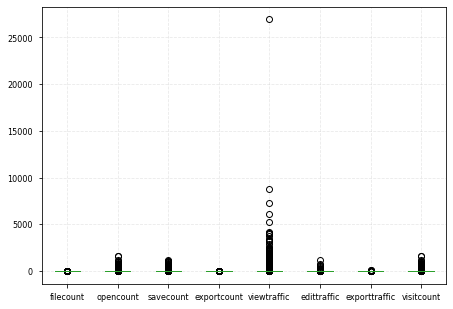

In [14]:
tf.plot(kind='box')

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

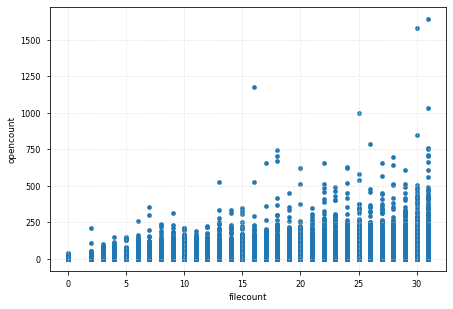

In [15]:
tf.plot(kind='scatter', x='filecount', y='opencount');

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

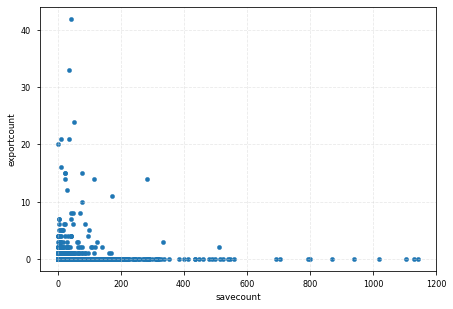

In [16]:
tf.plot(kind='scatter', x='savecount', y='exportcount');

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

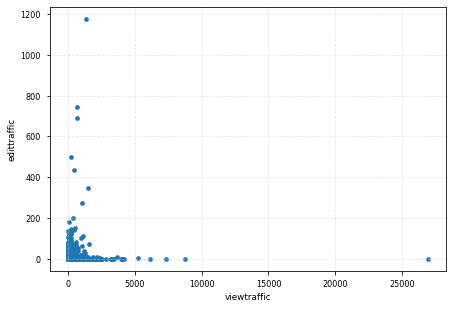

In [17]:
tf.plot(kind='scatter', x='viewtraffic', y='edittraffic');

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

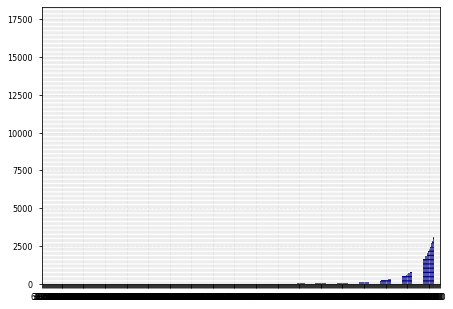

In [18]:
# 방문일수 분포 확인
tf['visitcount'].value_counts().sort_values().plot(kind='bar', color='darkblue', rot=0)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

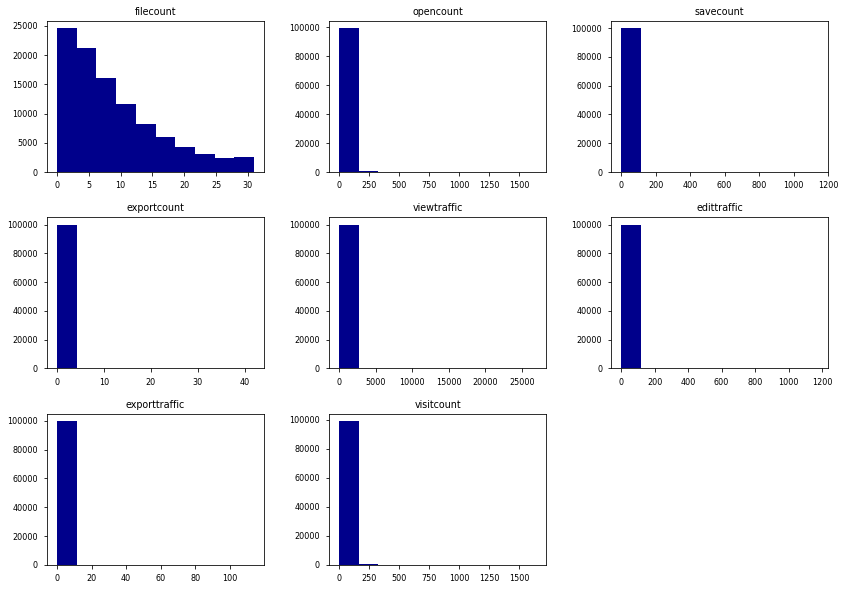

In [19]:
tf.hist(color='darkblue', figsize=(14,10), grid=False); 

In [20]:
# remove outliers
from scipy import stats

In [21]:
tf_zscore = tf[(np.abs(stats.zscore(tf)) < 3).all(axis=1)]

In [22]:
tf_zscore.describe().apply(lambda x: x.round(2))

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
count,96526.00,96526.00,96526.00,96526.0,96526.00,96526.00,96526.0,96526.00
mean,8.63,14.96,0.97,0.0,12.64,0.22,0.0,16.79
std,6.76,19.70,3.90,0.0,30.58,1.36,0.0,20.30
min,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
25%,3.00,0.00,0.00,0.0,0.00,0.00,0.0,3.00
50%,7.00,8.00,0.00,0.0,2.00,0.00,0.0,10.00
75%,12.00,21.00,0.00,0.0,11.00,0.00,0.0,23.00
max,30.00,116.00,48.00,0.0,385.00,20.00,0.0,122.00


In [23]:
def remove_outlier_std(df):
    for i in range(0, len(df.iloc[1])-1):
        df = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std()))]
    return df

In [24]:
tf_std = remove_outlier_std(tf)

In [25]:
tf_std.describe().apply(lambda x: x.round(2))

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
count,94852.00,94852.00,94852.00,94852.0,94852.00,94852.00,94852.0,94852.00
mean,8.51,14.28,0.71,0.0,11.37,0.10,0.0,16.42
std,6.70,18.76,2.64,0.0,25.60,0.58,0.0,20.66
min,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
25%,3.00,0.00,0.00,0.0,0.00,0.00,0.0,3.00
50%,7.00,7.00,0.00,0.0,2.00,0.00,0.0,9.00
75%,12.00,20.00,0.00,0.0,10.00,0.00,0.0,22.00
max,30.00,110.00,28.00,0.0,253.00,7.00,0.0,493.00


In [26]:
tf_std.drop(['exportcount', 'exporttraffic'], axis=1, inplace=True)

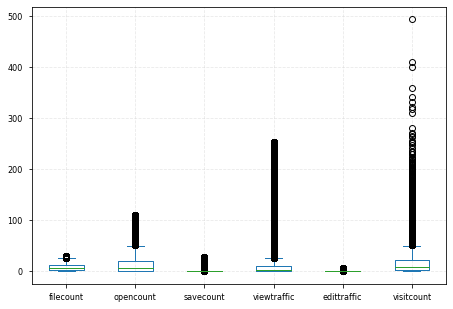

In [27]:
tf_std.plot(kind='box')

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [28]:
tf2 = tf_std.copy()

In [29]:
tf2.head()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount
iduser,,,,,,
10100018739106,6.0,12.0,0.0,3,0,12.0
10100037810674,8.0,23.0,0.0,16,0,23.0
10100036273719,4.0,4.0,0.0,2,0,4.0
10100027752244,5.0,6.0,2.0,1,0,6.0
10100000624840,24.0,0.0,0.0,0,0,0.0


In [30]:
# 추가 변수 생성
tf2['file_per_visit'] = (tf2['filecount'] / tf2['visitcount']).round(1)
tf2['count_per_visit'] = ((tf2['opencount'] + tf2['savecount']) / tf2['visitcount']).round(1)
tf2['traffic_per_visit'] = ((tf2['viewtraffic'] + tf2['edittraffic']) / tf2['visitcount']).round(1)

In [31]:
tf2.head()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit
iduser,,,,,,,,,
10100018739106,6.0,12.0,0.0,3,0,12.0,0.5,1.0,0.2
10100037810674,8.0,23.0,0.0,16,0,23.0,0.3,1.0,0.7
10100036273719,4.0,4.0,0.0,2,0,4.0,1.0,1.0,0.5
10100027752244,5.0,6.0,2.0,1,0,6.0,0.8,1.3,0.2
10100000624840,24.0,0.0,0.0,0,0,0.0,inf,NaN,NaN


In [32]:
tf2.describe().round(2)

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit
count,94852.00,94852.00,94852.00,94852.00,94852.00,94852.00,88787.0,77574.00,77574.00
mean,8.51,14.28,0.71,11.37,0.10,16.42,inf,0.94,0.79
std,6.70,18.76,2.64,25.60,0.58,20.66,NaN,0.38,1.78
min,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
25%,3.00,0.00,0.00,0.00,0.00,3.00,0.4,1.00,0.00
50%,7.00,7.00,0.00,2.00,0.00,9.00,0.6,1.00,0.30
75%,12.00,20.00,0.00,10.00,0.00,22.00,1.0,1.00,0.90
max,30.00,110.00,28.00,253.00,7.00,493.00,inf,12.50,104.00


In [33]:
tf2 = tf2.replace([np.inf, -np.inf], np.nan)

In [34]:
tf2.query("viewtraffic < 0")

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit
iduser,,,,,,,,,


In [35]:
tf2.loc[10100038687543,'viewtraffic'] = np.nan

In [36]:
tf2 = tf2.fillna(tf2.mean())

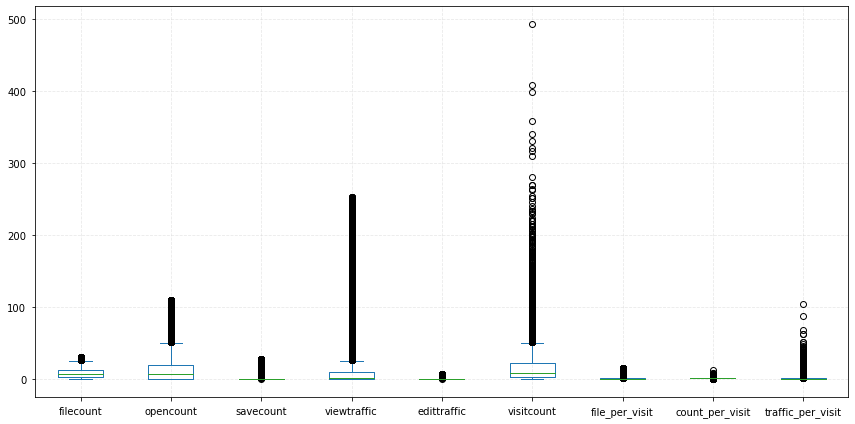

In [37]:
tf2.plot(kind='box', figsize=(12,6), fontsize=10)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### 두번째 데이터셋 조인
- 첫번째의 다음 주의 사용행동 데이터 => target variable(0, 1)

In [38]:
# 2ND week dataset
tf_2nd_wk = pd.read_csv("data/lc2.csv", index_col=0).set_index("iduser")

In [39]:
tf_2nd_wk.head()

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount
iduser,,,,,,,,
10100028558920,16.0,29.0,0.0,0.0,14253795.0,0.0,0.0,29.0
10100021195419,15.0,53.0,5.0,0.0,10441338.0,1197589.0,0.0,53.0
10100008824966,4.0,2.0,0.0,0.0,1197173.0,0.0,0.0,2.0
10100033605153,21.0,32.0,0.0,0.0,2281869.0,0.0,0.0,32.0
10100033331359,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# retention 여부만 관심
tf_2nd_wk['flag'] = True

In [41]:
tf_2nd_wk.head()

,filecount,opencount,savecount,exportcount,viewtraffic,edittraffic,exporttraffic,visitcount,flag
iduser,,,,,,,,,
10100028558920,16.0,29.0,0.0,0.0,14253795.0,0.0,0.0,29.0,True
10100021195419,15.0,53.0,5.0,0.0,10441338.0,1197589.0,0.0,53.0,True
10100008824966,4.0,2.0,0.0,0.0,1197173.0,0.0,0.0,2.0,True
10100033605153,21.0,32.0,0.0,0.0,2281869.0,0.0,0.0,32.0,True
10100033331359,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [42]:
tf_2nd_wk['flag'].to_frame().head(10)

,flag
iduser,
10100028558920,True
10100021195419,True
10100008824966,True
10100033605153,True
10100033331359,True
10100024849673,True
10100014948836,True
10100038252262,True
10100022708515,True


In [43]:
# 첫째, 둘째주차 데이터 조인
tf3 = pd.merge(tf2, tf_2nd_wk['flag'].to_frame(), left_index=True, right_index=True, how='left').fillna(False)

In [44]:
tf3.head()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit,flag
iduser,,,,,,,,,,
10100018739106,6.0,12.0,0.0,3.0,0.0,12.0,0.500000,1.000000,0.200000,False
10100037810674,8.0,23.0,0.0,16.0,0.0,23.0,0.300000,1.000000,0.700000,False
10100036273719,4.0,4.0,0.0,2.0,0.0,4.0,1.000000,1.000000,0.500000,False
10100027752244,5.0,6.0,2.0,1.0,0.0,6.0,0.800000,1.300000,0.200000,False
10100000624840,24.0,0.0,0.0,0.0,0.0,0.0,0.764402,0.938922,0.787157,False


In [45]:
tf3.flag.value_counts().to_frame().apply(lambda x: x/x.sum())

,flag
False,0.50049
True,0.49951


In [46]:
tf3.groupby("flag").mean()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit
flag,,,,,,,,,
False,8.571367,14.381886,0.718718,11.468632,0.105641,16.526287,0.769263,0.937620,0.787560
True,8.454073,14.183263,0.709856,11.276783,0.098417,16.312263,0.759531,0.940225,0.786753


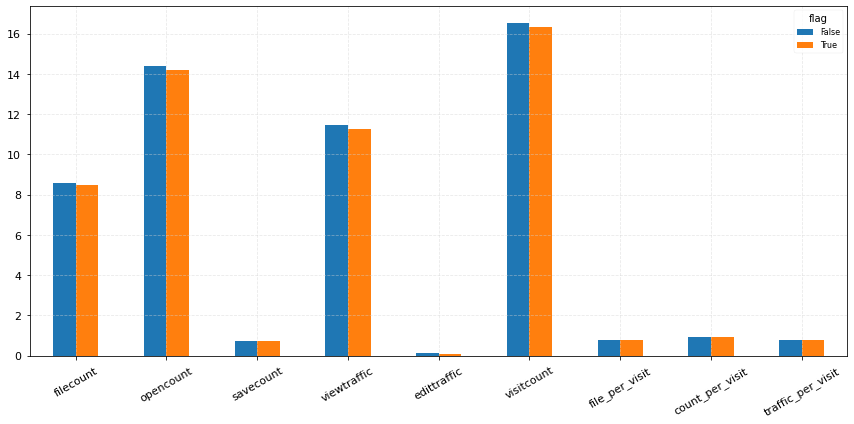

In [47]:
tf3.groupby("flag").mean().T.plot(kind='bar', figsize=(12,6), fontsize=11, rot=30);

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [48]:
tf3.groupby("flag").median()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit
flag,,,,,,,,,
False,7.0,7.0,0.0,2.0,0.0,9.0,0.7,1.0,0.5
True,7.0,7.0,0.0,2.0,0.0,9.0,0.7,1.0,0.5


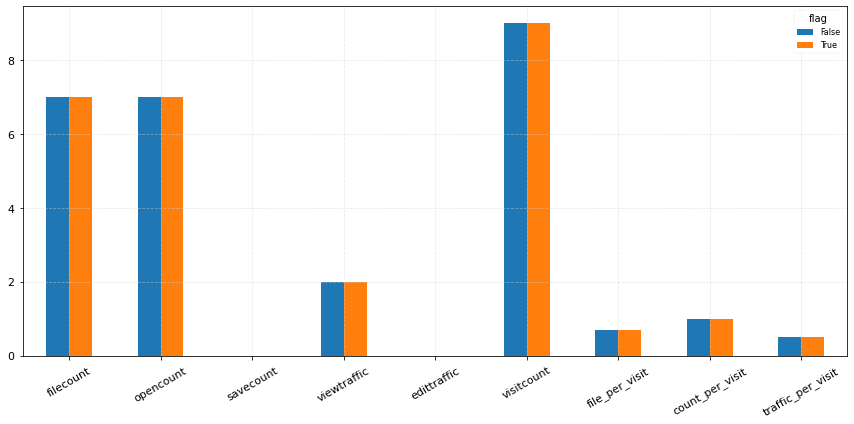

In [49]:
tf3.groupby("flag").median().T.plot(kind='bar', figsize=(12,6), fontsize=11, rot=30);

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### T-test 통해 통계적으로 유의미한 변수 확인
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [50]:
tf3.head()

,filecount,opencount,savecount,viewtraffic,edittraffic,visitcount,file_per_visit,count_per_visit,traffic_per_visit,flag
iduser,,,,,,,,,,
10100018739106,6.0,12.0,0.0,3.0,0.0,12.0,0.500000,1.000000,0.200000,False
10100037810674,8.0,23.0,0.0,16.0,0.0,23.0,0.300000,1.000000,0.700000,False
10100036273719,4.0,4.0,0.0,2.0,0.0,4.0,1.000000,1.000000,0.500000,False
10100027752244,5.0,6.0,2.0,1.0,0.0,6.0,0.800000,1.300000,0.200000,False
10100000624840,24.0,0.0,0.0,0.0,0.0,0.0,0.764402,0.938922,0.787157,False


In [51]:
from scipy.stats import ttest_ind

tf_churn = tf3[tf3['flag'] == 0]
tf_ret = tf3[tf3['flag'] == 1]

for i in range(0, 10):
    var1 = tf_churn.iloc[:,i]
    var2 = tf_ret.iloc[:,i]
    print(ttest_ind(var1, var2)) # only exportcount is not sig

Ttest_indResult(statistic=2.6957000604926167, pvalue=0.007025326863193838)
Ttest_indResult(statistic=1.6305547897898391, pvalue=0.10298761559398575)
Ttest_indResult(statistic=0.5174165257156319, pvalue=0.6048666326270542)
Ttest_indResult(statistic=1.1542473543273053, pvalue=0.24840168146171399)
Ttest_indResult(statistic=1.9068238114053064, pvalue=0.05654642500876093)
Ttest_indResult(statistic=1.5952138320132772, pvalue=0.11066775832879738)
Ttest_indResult(statistic=1.7586804992308682, pvalue=0.07863501573897991)
Ttest_indResult(statistic=-1.1689168826608314, pvalue=0.24244005845724242)
Ttest_indResult(statistic=0.07718242659385971, pvalue=0.938478584281684)
Ttest_indResult(statistic=-inf, pvalue=0.0)


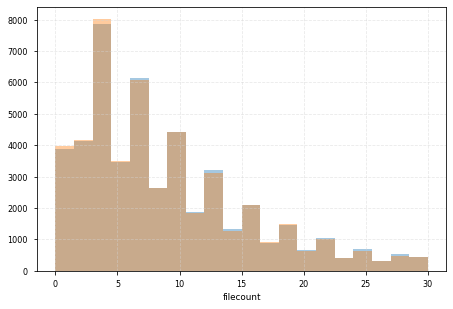

In [52]:
sns.distplot(tf_churn['filecount'], kde=False, bins=20)
sns.distplot(tf_ret['filecount'], kde=False, bins=20)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

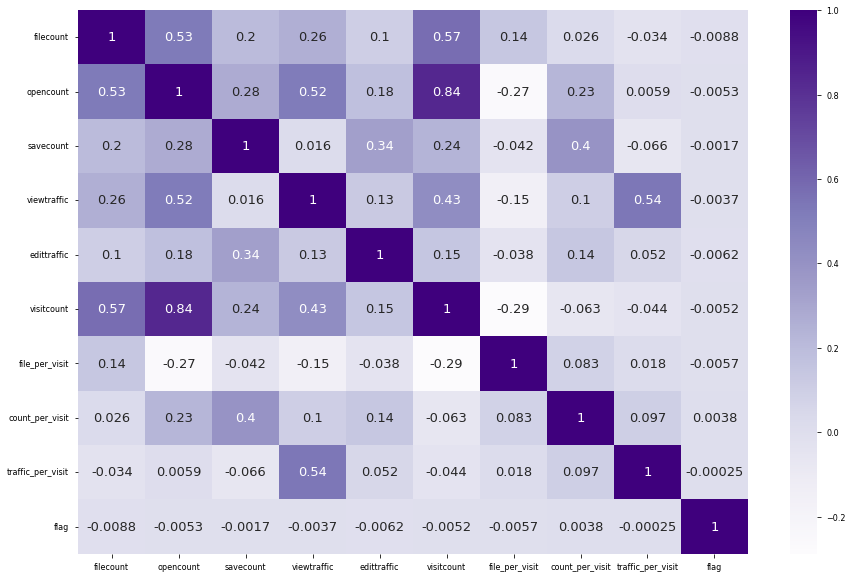

In [53]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(tf3.corr(), annot=True, annot_kws={"size": 13}, cmap='Purples');

In [54]:
drop_cols = ['filecount', 'traffic_per_visit']

tf3.drop(drop_cols, axis=1, inplace=True)

###  변수별 영향력 도출

- 데이터 표준화 (scaling)
- 모델 학습 및 예측
- 로지스틱 회귀를 이용한 coefficient 도출
- 랜덤포레스트를 이용한 영향력 도출
- 반복적 변수 제거 방식(RFE)을 이용한 변수별 중요도 도출

In [55]:
tf3['flag'] = np.where(tf3.flag == True, 1, 0)

In [56]:
tf3.flag.value_counts()

0    47473
1    47380
Name: flag, dtype: int64

In [57]:
from sklearn.model_selection import train_test_split

X = tf3.drop("flag", axis=1)
y = tf3.flag

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(71139, 7)
(71139,)
(23714, 7)
(23714,)


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [60]:
def pipeline_logit(X_train, y_train):

    scaler = StandardScaler()
    select = SelectKBest(score_func=f_classif)
    logit_model = LogisticRegression()

    pipe = Pipeline([('scaler', scaler), ('feature_selection', select), ('model', logit_model)])

    param_grid = [{'feature_selection__k': [5, 'all'],
                   'model__C': [0.01, 0.1, 1],
                   'model__penalty': ['l1', 'l2']}]

    grid_search = GridSearchCV(pipe, param_grid, cv=2)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [61]:
grid_search = pipeline_logit(X_train, y_train)

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [63]:
def model_evaluation(grid, X_test, y_test):
    
    print(classification_report(grid.predict(X_test), y_test))
    print("")
    print("best score: ", grid.best_score_)
    print("best params: ", grid.best_params_)

    fpr, tpr, thresholds = roc_curve(y_test, grid.predict(X_test))
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [64]:
model_evaluation(grid_search, X_test, y_test)

              precision    recall  f1-score   support

           0       0.33      0.51      0.40      7650
           1       0.68      0.50      0.58     16064

    accuracy                           0.51     23714
   macro avg       0.51      0.51      0.49     23714
weighted avg       0.57      0.51      0.52     23714


best score:  0.5020171700309866
best params:  {'feature_selection__k': 'all', 'model__C': 0.01, 'model__penalty': 'l2'}


0.5073320959210014

Text(0.5, 0, 'False Positive Rate')

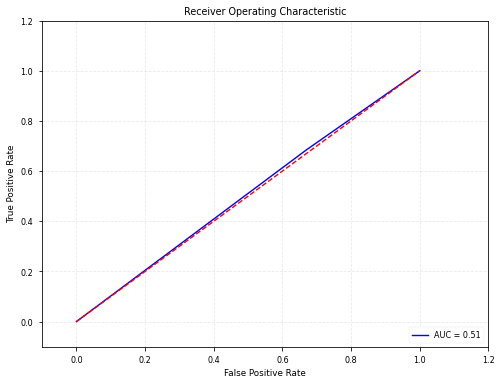

In [65]:
# ROC plot
fig = plt.figure(figsize=(8,6))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, grid_search.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [66]:
mask = grid_search.best_estimator_.named_steps['feature_selection'].get_support().tolist()

mask

[True, True, True, True, True, True, True]

In [67]:
features_list = list(X_train.columns.values)

features_list

['opencount',
 'savecount',
 'viewtraffic',
 'edittraffic',
 'visitcount',
 'file_per_visit',
 'count_per_visit']

In [68]:
selected_features = []

for bool, features in zip(mask, features_list):
    if bool:
        selected_features.append(features)

In [69]:
selected_features

['opencount',
 'savecount',
 'viewtraffic',
 'edittraffic',
 'visitcount',
 'file_per_visit',
 'count_per_visit']

In [70]:
feature_importance = grid_search.best_estimator_.named_steps['model'].coef_.ravel().tolist()

feature_importance

[-0.01923098281226735,
 -0.005490839474115111,
 -0.005751398670813771,
 -0.010131999999304909,
 0.0079921435287552,
 -0.00782090687967632,
 0.017161201567990902]

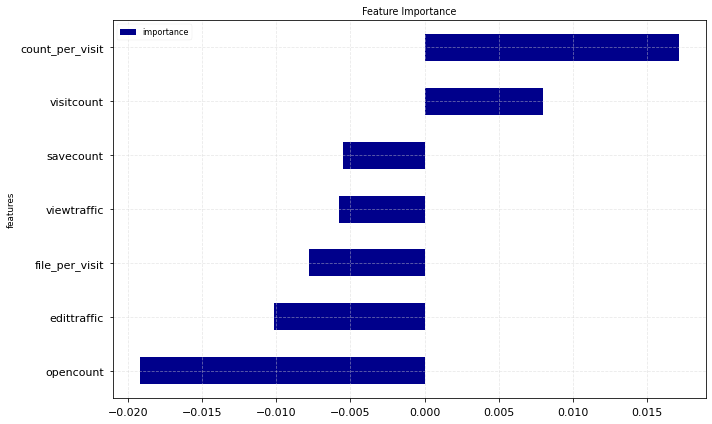

In [71]:
# create a df       
feature_importance_pd = pd.DataFrame(list(zip(selected_features, feature_importance)),\
                                    columns=['features', 'importance'])\
                          .set_index("features").sort_values("importance")

feature_importance_pd.plot(kind='barh', color='darkblue', figsize=(10,6), fontsize=11);

plt.title("Feature Importance")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [72]:
## Tree-based feature importance
from sklearn.ensemble import ExtraTreesClassifier

In [73]:
def pipeline_tree_kbest(X_train, y_train):

    select = SelectKBest()
    extra_tree_model = ExtraTreesClassifier()

    pipe = Pipeline([('feature_selection', select), ('model', extra_tree_model)])

    param_grid = [{'feature_selection__k': [5, 'all'],
                   'model__max_depth': [4, 10], # max_depth: The maximum depth of the tree.
                   'model__n_estimators': [10, 20], # n_estimators: The number of trees in the forest.
                   'model__min_samples_split': [50, 100]}]

    grid_search = GridSearchCV(pipe, param_grid, cv=2)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [74]:
grid_search_tree = pipeline_tree_kbest(X_train, y_train)

In [75]:
model_evaluation(grid_search_tree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.33      0.51      0.40      7780
           1       0.67      0.50      0.57     15934

    accuracy                           0.50     23714
   macro avg       0.50      0.50      0.49     23714
weighted avg       0.56      0.50      0.52     23714


best score:  0.503479083245193
best params:  {'feature_selection__k': 5, 'model__max_depth': 4, 'model__min_samples_split': 100, 'model__n_estimators': 20}


0.5019084283718883

Text(0.5, 0, 'False Positive Rate')

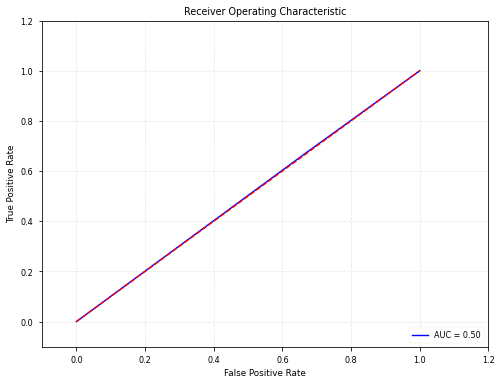

In [76]:
# ROC plot
fig = plt.figure(figsize=(8,6))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, grid_search_tree.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [77]:
mask = grid_search_tree.best_estimator_.named_steps['feature_selection'].get_support()
feature_importance = grid_search_tree.best_estimator_.named_steps['model'].feature_importances_

features_list = list(X_train.columns.values)

selected_features = []
for bool, features in zip(mask, features_list):
    if bool:
        selected_features.append(features)

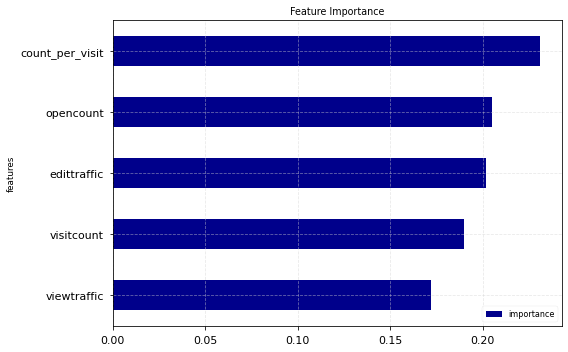

In [78]:
feature_importance_pd = pd.DataFrame(list(zip(selected_features, feature_importance)),\
                                    columns=['features', 'importance'])\
                          .set_index("features").sort_values("importance")

feature_importance_pd.plot(kind='barh', color='darkblue', figsize=(8,5), fontsize=11);

plt.title("Feature Importance")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

**Note**
- **Key variable: visitcount**

### 그룹별 리텐션 여부 데이터셋
- 주요 변수 1개만 선정: **visitcount** (range: 1~7)
- group: 유저의 visitcount 기준으로 그룹 부여
    - 만약 특정주에 1일 들어왔으면, group = 1
- isnextvisit: 다음주의 재방문 여부
    - 0: 방문 안함
    - 1: 방문함
- day: group 산정일 기준
    - day 의 날짜 이전 일주일간의 데이터로 group 산정

In [79]:
sf = pd.read_csv("data/df_lc.csv", index_col=0)

In [80]:
# group = visitcount
sf.head(10)

,isnextvisit,day
group,,
1,0,2016-10-15
1,0,2016-10-15
1,0,2016-10-15
2,1,2016-10-15
2,1,2016-10-15
1,0,2016-10-15
2,1,2016-10-15
2,0,2016-10-15
1,0,2016-10-15


In [81]:
sf.tail()

,isnextvisit,day
group,,
1,1,2017-02-04
1,1,2017-02-04
3,1,2017-02-04
2,1,2017-02-05
2,1,2017-02-05


In [82]:
sf.shape

(867, 2)

In [83]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 1 to 2
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   isnextvisit  867 non-null    int64 
 1   day          867 non-null    object
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [84]:
sf['day'] = pd.to_datetime(sf['day'])

In [85]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 1 to 2
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   isnextvisit  867 non-null    int64         
 1   day          867 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.3 KB


In [86]:
sf.day.value_counts().sort_index()

2016-10-15    41
2016-10-16    13
2016-10-17     6
2016-10-18     6
2016-10-19    36
              ..
2017-02-01     9
2017-02-02     9
2017-02-03     9
2017-02-04     9
2017-02-05     6
Name: day, Length: 114, dtype: int64

In [87]:
# 그룹별 리텐션 비율
sf_ret = sf.groupby(['group', 'isnextvisit']).size().unstack()
sf_ret

isnextvisit,0,1
group,,
1,243,164
2,128,166
3,97,69


In [88]:
sf_ret.columns = ['churn', 'retention']
sf_ret

,churn,retention
group,,
1,243,164
2,128,166
3,97,69


In [89]:
# FQ7 index
sf_ret_rt = sf_ret.apply(lambda x: x/x.sum() * 100, axis=1).round(2).reset_index()

sf_ret_rt

,group,churn,retention
0,1,59.71,40.29
1,2,43.54,56.46
2,3,58.43,41.57


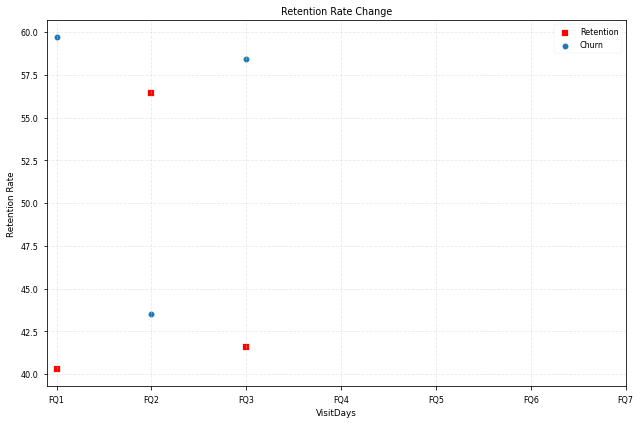

In [90]:
fig, ax = plt.subplots(figsize=(9,6))

plt.scatter(sf_ret_rt.group, sf_ret_rt.retention, color='r', label="Retention", marker=',')
plt.scatter(sf_ret_rt.group, sf_ret_rt.churn, label="Churn")

plt.title("Retention Rate Change")
plt.ylabel("Retention Rate")
plt.xlabel("VisitDays")
plt.xticks([1,2,3,4,5,6,7], ['FQ1', 'FQ2', 'FQ3', 'FQ4', 'FQ5', 'FQ6', 'FQ7'])
plt.legend()
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

- Note 
 - FQ4 is the cut-line as saturated

## Day05-3B 신규 지표 개발 (실습) - 스코어 산출 및 대시보드 구축

- Logistic regression에서 변수별 coefficient 활용 ✓
    - reference: http://blog.yhat.com/posts/logistic-regression-and-python.html
    - another option: Random Forest's Feature Importance
<img src="kui_frame.png" width="650">    

### 변수별 영향력 산출

In [91]:
sf.head(10)

,isnextvisit,day
group,,
1,0,2016-10-15
1,0,2016-10-15
1,0,2016-10-15
2,1,2016-10-15
2,1,2016-10-15
1,0,2016-10-15
2,1,2016-10-15
2,0,2016-10-15
1,0,2016-10-15


In [92]:
sf.day.value_counts().sort_index()

2016-10-15    41
2016-10-16    13
2016-10-17     6
2016-10-18     6
2016-10-19    36
              ..
2017-02-01     9
2017-02-02     9
2017-02-03     9
2017-02-04     9
2017-02-05     6
Name: day, Length: 114, dtype: int64

In [93]:
# 하루치 데이터로 베타값 산출 시도
# 특정 하루의 데이터셋만 가지고 회귀분석

firstday = '2016-10-15'
sf_firstday = sf[sf['day'] == firstday].drop('day', axis=1)

sf_firstday.head()

,isnextvisit
group,
1,0
1,0
1,0
2,1
2,1


In [94]:
sf_firstday.groupby(["group", "isnextvisit"]).size().unstack().apply(lambda x: x/x.sum() * 100, axis=1).round(2)

isnextvisit,0,1
group,,
1,80.95,19.05
2,40.00,60.00


In [95]:
sf_firstday = sf_firstday.reset_index()

In [96]:
sf_firstday_dum = pd.get_dummies(sf_firstday['group'], prefix='FQ').join(sf_firstday.isnextvisit)

In [97]:
sf_firstday_dum.head()

,FQ_1,FQ_2,isnextvisit
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,1
4,0,1,1


In [98]:
# to check p-values via statsmodel
from sklearn.model_selection import train_test_split

In [99]:
sf_firstday_dum['intercept'] = 1.0

X = sf_firstday_dum.drop(['isnextvisit', 'FQ_1'], axis=1)
y = sf_firstday_dum.isnextvisit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [100]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30, 2)
(30,)
(11, 2)
(11,)


In [101]:
import statsmodels.api as sm

In [102]:
logreg_sm = sm.Logit(y_train, X_train)
result = logreg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.542014
         Iterations 5


In [103]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            isnextvisit   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Apr 2023   Pseudo R-squ.:                  0.1485
Time:                        16:54:19   Log-Likelihood:                -16.260
converged:                       True   LL-Null:                       -19.095
Covariance Type:            nonrobust   LLR p-value:                   0.01726
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FQ_2           1.9459      0.862      2.258      0.024       0.257       3.635
intercept     -1.6094      0.632     -2.545      0.011      -2.849      -0.370
==============================================================================
"""

In [104]:
sf.head()

,isnextvisit,day
group,,
1,0,2016-10-15
1,0,2016-10-15
1,0,2016-10-15
2,1,2016-10-15
2,1,2016-10-15


In [105]:
sf = sf.reset_index()

In [106]:
## 하루가 아니라 여러날의 데이터를 모두 고려
# 가중치(coeffienct) 평균 산출하기

sf1 = pd.get_dummies(sf.group, prefix='FQ')\
                 .join(sf.isnextvisit)\
                 .join(sf.day)\
                 .drop("FQ_1", axis=1)

In [107]:
X = sf1.drop(['isnextvisit', 'day'], axis=1)

In [108]:
#sf1['day'].unique()

In [109]:
from sklearn.linear_model import LogisticRegression
from datetime import timedelta

In [110]:
dates = pd.to_datetime('2016-10-15')

In [111]:
for i in range(0, sf1['day'].nunique()):
    subset = sf1[sf1['day'] == dates]
    subset['intercept'] = 1.0

    X = subset.drop(['isnextvisit', 'day'], axis=1)
    y = subset.isnextvisit

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    logreg = LogisticRegression().fit(X_train, y_train)
  
    print("date :", dates, "score :", logreg.score(X_test, y_test))
    print(logreg.coef_.flatten())

    dates = dates + timedelta(days=1)

date : 2016-10-15 00:00:00 score : 0.45454545454545453
[1.15312127e+00 0.00000000e+00 1.05640537e-04]
date : 2016-10-16 00:00:00 score : 0.75
[-1.40792267e-06  0.00000000e+00 -2.20241960e-06]
date : 2016-10-17 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-18 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-19 00:00:00 score : 0.4444444444444444
[ 1.22191402e-01 -4.12982521e-01 -4.35126188e-07]
date : 2016-10-20 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-21 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-22 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-23 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-24 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-25 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-26 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-27 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-28 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-29 00:00:00 score : 1.0
[0. 0. 0.]
date : 2016-10-30 00:00:00 score : 0.0
[0. 0. 0.]
date : 2016-10-31 00:00:00 score : 1.0
[0. 0. 0.]
date

In [112]:
#sf1['day'].unique()[2]

In [113]:
from datetime import timedelta

In [114]:
dates = pd.to_datetime('2016-10-15')

In [115]:
score = []
beta = pd.DataFrame()

In [116]:
for i in range(0, sf1['day'].nunique()):
    subset = sf1[sf1['day'] == dates]
    subset['intercept'] = 1.0

    X = subset.drop(['isnextvisit', 'day'], axis=1)
    y = subset.isnextvisit

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    logreg = LogisticRegression().fit(X_train, y_train)
  
    score.append(logreg.score(X_test, y_test))
    beta = beta.append(pd.DataFrame(logreg.coef_))

    dates = dates + timedelta(days=1)

In [117]:
score

[0.45454545454545453,
 0.75,
 0.0,
 0.0,
 0.4444444444444444,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.66666

In [118]:
print(np.array(score).mean())

0.6080320751373383


In [119]:
beta.head()

,0,1,2
0,1.153121,0.000000,1.056405e-04
0,-0.000001,0.000000,-2.202420e-06
0,0.000000,0.000000,0.000000e+00
0,0.000000,0.000000,0.000000e+00
0,0.122191,-0.412983,-4.351262e-07


In [120]:
coef_df = beta.reset_index(drop=True)
coef_df.columns = X_train.columns

coef_df.index = sf1.day.unique()
coef_df.sort_index(inplace=True)

coef_df

,FQ_2,FQ_3,intercept
2016-10-15,1.153121,0.000000,1.056405e-04
2016-10-16,-0.000001,0.000000,-2.202420e-06
2016-10-17,0.000000,0.000000,0.000000e+00
2016-10-18,0.000000,0.000000,0.000000e+00
2016-10-19,0.122191,-0.412983,-4.351262e-07
...,...,...,...
2017-02-01,0.000000,0.000004,4.311800e-06
2017-02-02,0.000000,0.256419,-5.820703e-06
2017-02-03,0.000000,0.256419,-5.820703e-06
2017-02-04,0.000000,0.256419,-5.820703e-06


In [121]:
# cofficient value
coef_df.mean()

FQ_2        -0.030033
FQ_3         0.096336
intercept   -0.000002
dtype: float64

In [122]:
# odd ratio
np.exp(coef_df.mean())

FQ_2         0.970413
FQ_3         1.101129
intercept    0.999998
dtype: float64

###  변수별 가중치 반영하여 스코어 산출

In [123]:
sf.head()

,group,isnextvisit,day
0,1,0,2016-10-15
1,1,0,2016-10-15
2,1,0,2016-10-15
3,2,1,2016-10-15
4,2,1,2016-10-15


In [124]:
daily_score = sf.groupby(['day', 'group']).size().unstack()

daily_score.head()

group,1,2,3
day,,,
2016-10-15,21.0,20.0,NaN
2016-10-16,8.0,4.0,1.0
2016-10-17,6.0,NaN,NaN
2016-10-18,NaN,6.0,NaN
2016-10-19,18.0,6.0,12.0


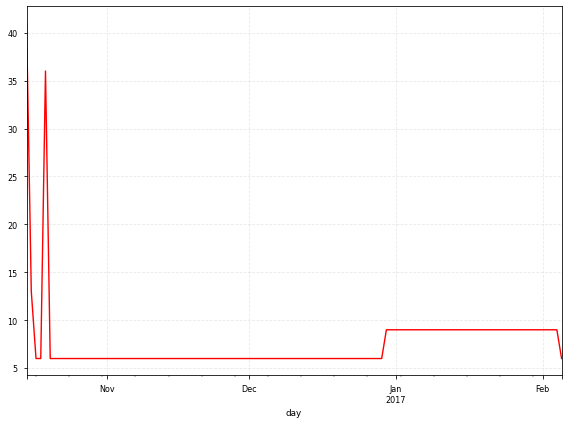

In [125]:
# without weights
daily_score.sum(axis=1).plot(color='red', figsize=(8,6));

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [126]:
daily_score.loc['2016-10-15':,]

group,1,2,3
day,,,
2016-10-15,21.0,20.0,NaN
2016-10-16,8.0,4.0,1.0
2016-10-17,6.0,NaN,NaN
2016-10-18,NaN,6.0,NaN
2016-10-19,18.0,6.0,12.0
...,...,...,...
2017-02-01,NaN,NaN,9.0
2017-02-02,6.0,NaN,3.0
2017-02-03,6.0,NaN,3.0


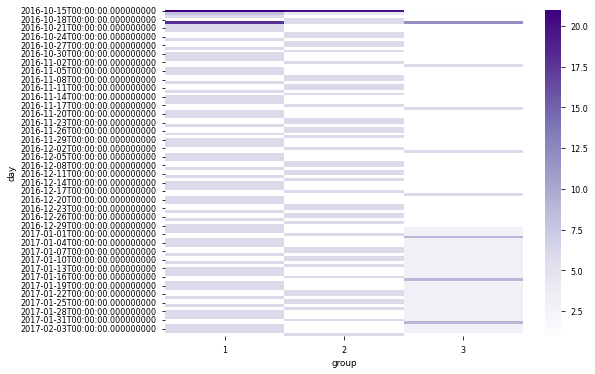

In [127]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(daily_score, annot=False, cmap='Purples');

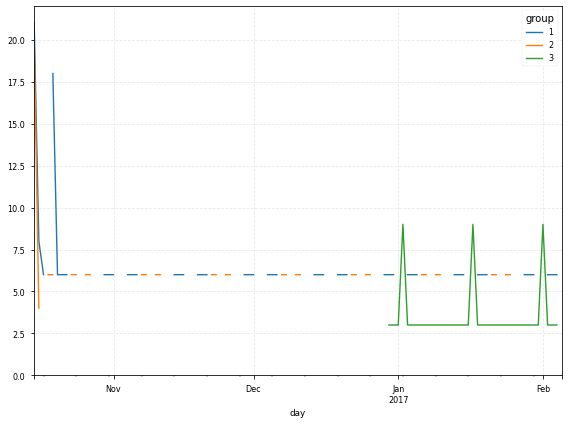

In [128]:
# without weights => bar, stacked=True
daily_score.plot(figsize=(8,6));

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [129]:
# odd ratio
np.exp(coef_df.mean())

FQ_2         0.970413
FQ_3         1.101129
intercept    0.999998
dtype: float64

In [130]:
weight = [x for x in np.exp(coef_df.mean())][:-1]
weight.insert(0, 1.0)

weight

[1.0, 0.9704133694069961, 1.1011293849680481]

In [131]:
daily_score_weight = daily_score.copy()

In [132]:
daily_score_weight#.iloc[:, i]

group,1,2,3
day,,,
2016-10-15,21.0,20.0,NaN
2016-10-16,8.0,4.0,1.0
2016-10-17,6.0,NaN,NaN
2016-10-18,NaN,6.0,NaN
2016-10-19,18.0,6.0,12.0
...,...,...,...
2017-02-01,NaN,NaN,9.0
2017-02-02,6.0,NaN,3.0
2017-02-03,6.0,NaN,3.0


In [133]:
for i in range(1, 3):
    daily_score_weight.iloc[:, i] = (daily_score_weight.iloc[:, i] * weight[i-0]).apply(lambda x: round(x, 2))

In [134]:
daily_score_weight.head()

group,1,2,3
day,,,
2016-10-15,21.0,19.41,NaN
2016-10-16,8.0,3.88,1.10
2016-10-17,6.0,NaN,NaN
2016-10-18,NaN,5.82,NaN
2016-10-19,18.0,5.82,13.21


In [135]:
daily_score_weight['kui'] = daily_score_weight.sum(axis=1)

In [136]:
daily_score_weight.head()

group,1,2,3,kui
day,,,,
2016-10-15,21.0,19.41,NaN,40.41
2016-10-16,8.0,3.88,1.10,12.98
2016-10-17,6.0,NaN,NaN,6.00
2016-10-18,NaN,5.82,NaN,5.82
2016-10-19,18.0,5.82,13.21,37.03


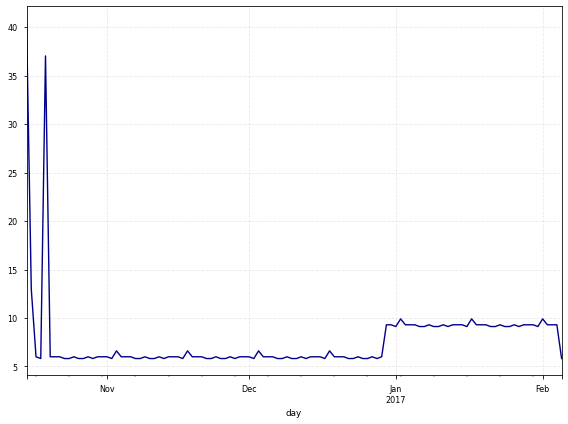

In [137]:
daily_score_weight['kui'].plot(figsize=(8,6), color='darkblue')

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

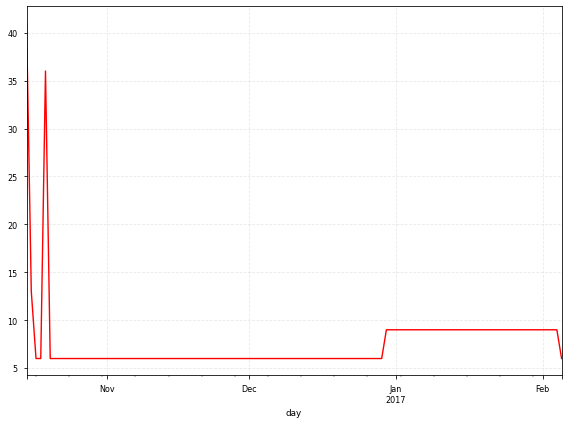

In [138]:
daily_score.sum(axis=1).plot(color='red', figsize=(8,6));

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [139]:
daily_score_weight#.loc['2016-10-15':,]

group,1,2,3,kui
day,,,,
2016-10-15,21.0,19.41,NaN,40.41
2016-10-16,8.0,3.88,1.10,12.98
2016-10-17,6.0,NaN,NaN,6.00
2016-10-18,NaN,5.82,NaN,5.82
2016-10-19,18.0,5.82,13.21,37.03
...,...,...,...,...
2017-02-01,NaN,NaN,9.91,9.91
2017-02-02,6.0,NaN,3.30,9.30
2017-02-03,6.0,NaN,3.30,9.30


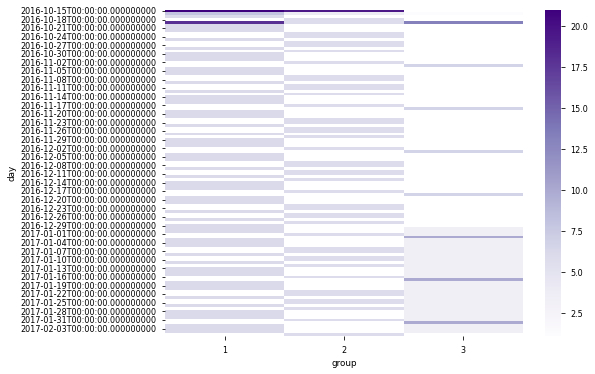

In [140]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(daily_score_weight.drop("kui", axis=1), annot=False, cmap='Purples');

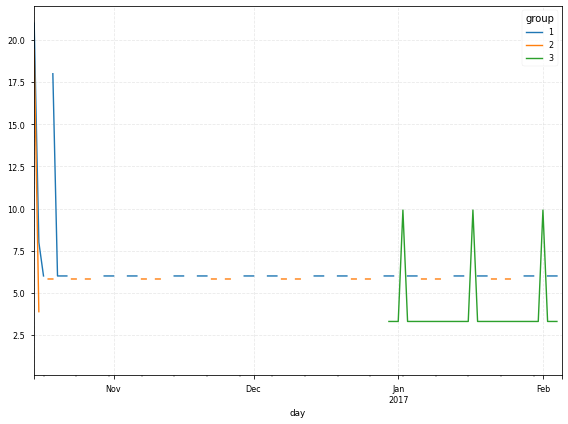

In [141]:
daily_score_weight.drop('kui', axis=1).plot(figsize=(8,6));

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

- Reference
    - http://blog.yhat.com/posts/logistic-regression-and-python.html
    - http://www.appstate.edu/~whiteheadjc/service/logit/intro.htm
    - http://www.cbgstat.com/method_logistic_regression_analysis/logistic_regression_analysis.php

### Dashboard 생성
 - Redash: https://redash.io/
 - plotly: https://plot.ly/feed/#/
     - line chart example: https://plot.ly/python/line-charts/
 - creat a dashboard: https://plot.ly/create/

In [142]:
daily_score_weight.to_csv('data/daily_score.csv')